# Sampling MNIST Autoencoder Manifolds
** March 2018 **

** Andrew Riberio @ [AndrewRib.com](http://www.andrewrib.com) **

<p align="center">
    <img width="300" height="300" src="https://i.imgur.com/MJ9Wf7q.png" />
    <br/>
</p>
In this notebook we will explore the notion of using the vector field ( gradient ) learned by an autoencoder in order to sample from an autoencoder trained on various digit classes in the MNIST dataset. This investigation came from our ongoing study of the deep learning book, [chapter 14](http://www.deeplearningbook.org/contents/autoencoders.html) specifically -- which is where the above image is sourced.

Resources
* https://www.tensorflow.org/get_started/mnist/beginners
* https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras import losses
from keras.callbacks import EarlyStopping
from tensorflow.examples.tutorials.mnist import input_data
from keras import backend as K
import tensorflow as tf
from ipywidgets import interact_manual,interact
import pandas as pd
from keras.models import load_model

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True,device_count = {'CPU' : 1, 'GPU' : 0}))
K.set_session(sess)
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

# First we will zip the training labels with the training images
dataWithLabels = zip(mnist.train.labels, mnist.train.images)

# Now let's turn this into a dictionary where subsets of the images in respect 
# to digit class are stored via the corresponding key.

# Init dataDict with keys [0,9] and empty lists.
digitDict = {}
for i in range(0,10):
    digitDict[i] = []

# Assign a list of image vectors to each corresponding digit class index. 
for i in dataWithLabels:
    digitDict[i[0]].append(i[1])

# Convert the lists into numpy matricies. (could be done above, but I claim ignorace)
for i in range(0,10):
    digitDict[i] = np.matrix(digitDict[i])
    print("Digit {0} matrix shape: {1}".format(i,digitDict[i].shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Digit 0 matrix shape: (5444, 784)
Digit 1 matrix shape: (6179, 784)
Digit 2 matrix shape: (5470, 784)
Digit 3 matrix shape: (5638, 784)
Digit 4 matrix shape: (5307, 784)
Digit 5 matrix shape: (4987, 784)
Digit 6 matrix shape: (5417, 784)
Digit 7 matrix shape: (5715, 784)
Digit 8 matrix shape: (5389, 784)
Digit 9 matrix shape: (5454, 784)


In [4]:
def simpleAE(encoding_dim = 32, input_dim = 784,  midActivation='relu',  outActivation='relu'):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation=midActivation)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation=outActivation)(encoded)

    # this model maps an input to its reconstruction
    return Model(input_img, decoded)

def sampleAE(autoEnc):
    w=10
    h=10
    fig=plt.figure(figsize=(20, 20))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        res = autoEnc.predict(np.random.binomial(1,.5,(1,28*28)))
        fig.add_subplot(rows, columns, i)
        # For pretty pics, add the argument - interpolation="bicubic"
        plt.imshow(res.reshape(28,28),cmap="gray")
    plt.show()

In [180]:
ae1 = simpleAE(10,784,'sigmoid', 'sigmoid')
ae1.compile(optimizer='adadelta', loss='binary_crossentropy')

history = ae1.fit(digitDict[1], digitDict[1],
                    epochs=100,
                    batch_size=1,verbose=1)

Epoch 1/100
6179/6179 [==============================] - 64s 10ms/step - loss: 0.1687
Epoch 2/100
6179/6179 [==============================] - 5s 751us/step - loss: 0.1290
Epoch 3/100
6179/6179 [==============================] - 5s 753us/step - loss: 0.1268
Epoch 4/100
6179/6179 [==============================] - 5s 748us/step - loss: 0.1246
Epoch 5/100
6179/6179 [==============================] - 5s 746us/step - loss: 0.1135
Epoch 6/100
6179/6179 [==============================] - 5s 745us/step - loss: 0.1015
Epoch 7/100
6179/6179 [==============================] - 5s 746us/step - loss: 0.0923
Epoch 8/100
6179/6179 [==============================] - 5s 743us/step - loss: 0.0877
Epoch 9/100
6179/6179 [==============================] - 5s 747us/step - loss: 0.0851
Epoch 10/100
6179/6179 [==============================] - 5s 746us/step - loss: 0.0833
Epoch 11/100
6179/6179 [==============================] - 5s 746us/step - loss: 0.0818
Epoch 12/100
6179/6179 [============================

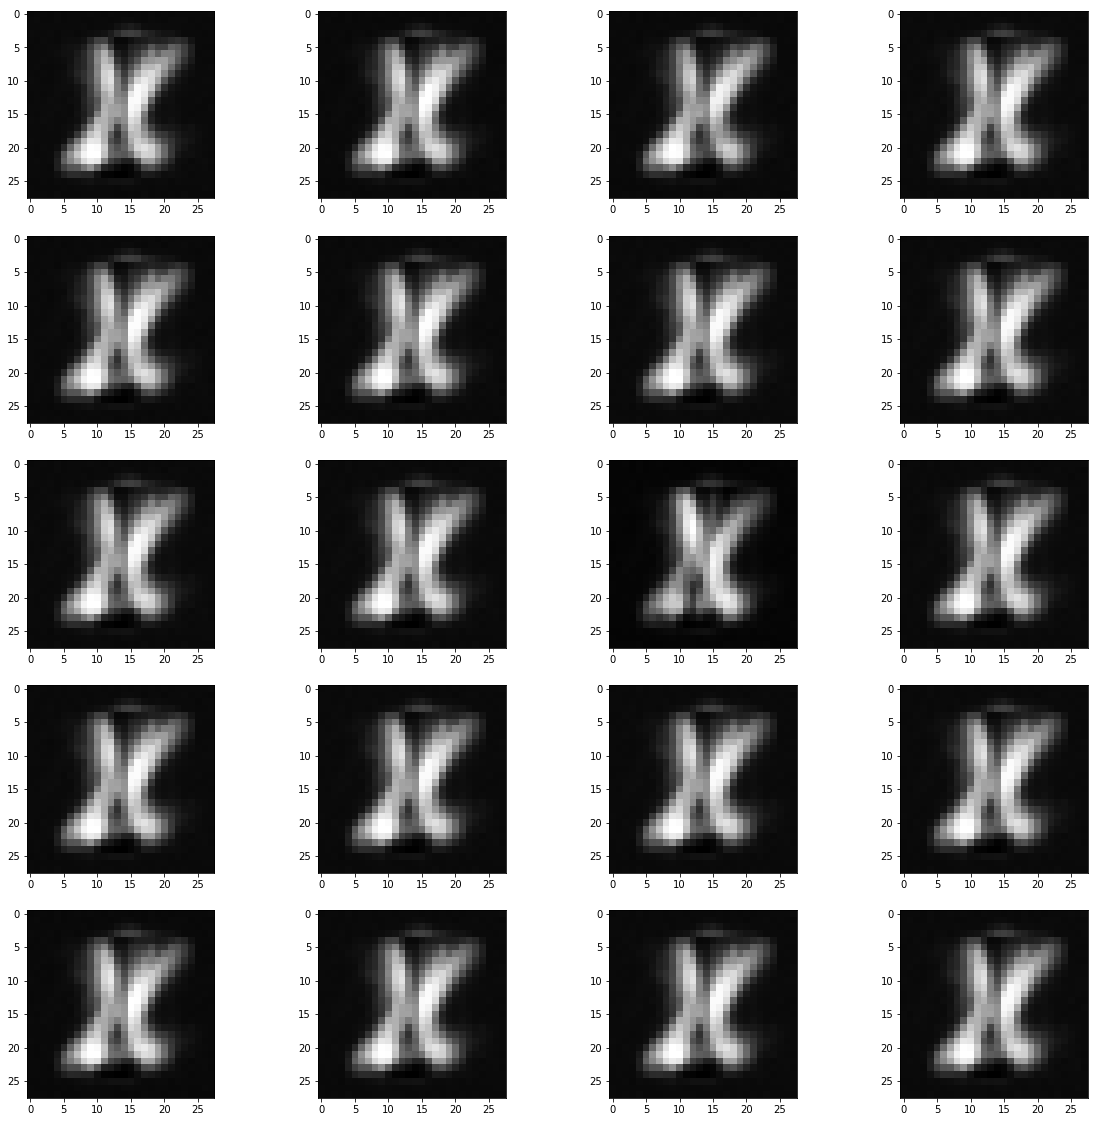

In [181]:
sampleAE(ae1)

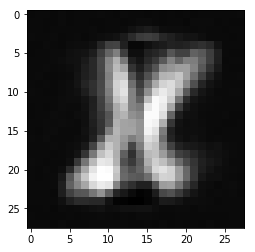

In [182]:
gradients = K.gradients(ae1.output,ae1.input)
randSample = np.random.binomial(1,.5,(1,28*28))
evaluated_gradients = sess.run(gradients,feed_dict={ae1.input:randSample})
res = ae1.predict( randSample-0.01*evaluated_gradients[0][0] )
plt.imshow( res.reshape(28,28),cmap="gray" )
plt.show()

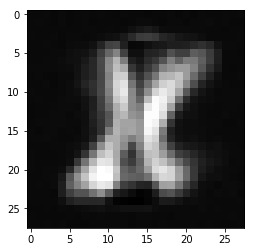

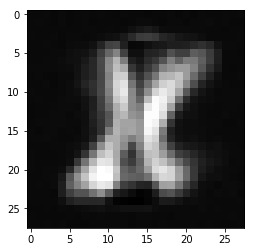

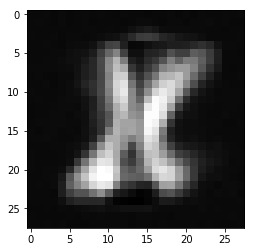

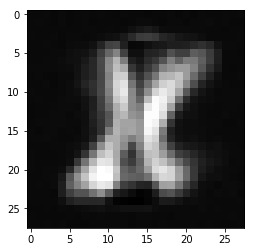

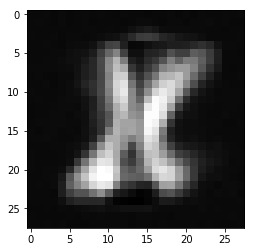

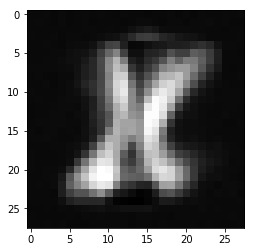

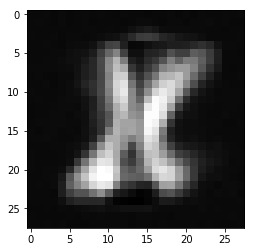

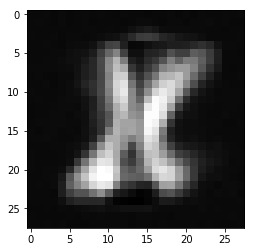

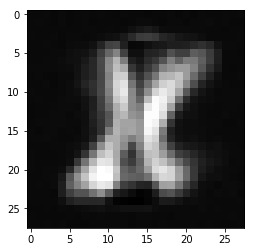

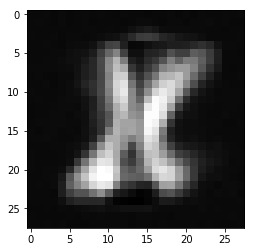

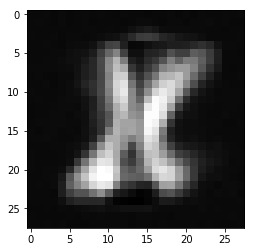

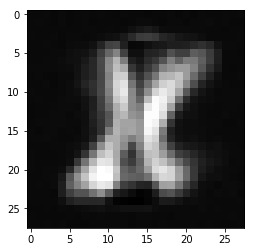

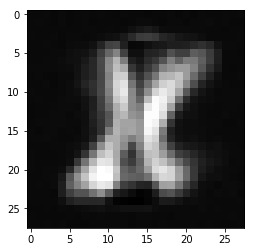

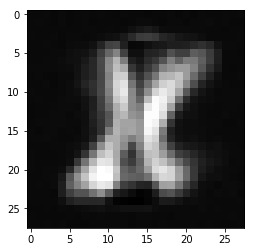

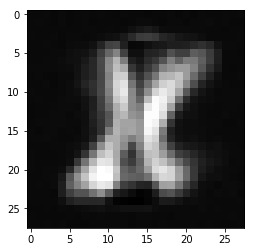

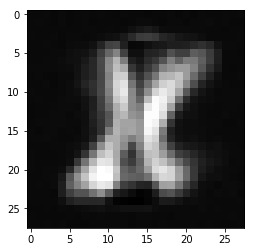

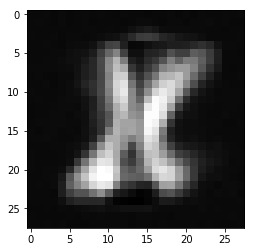

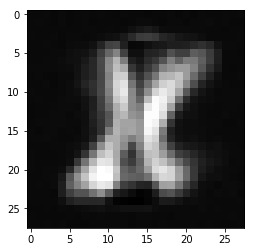

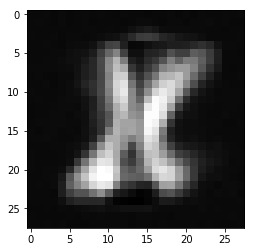

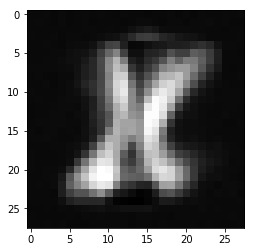

In [201]:
coef = 1

gradients = K.gradients(ae1.output,ae1.input)
randSample = np.random.binomial(1,.5,(1,28*28))
res = ae1.predict(randSample)
evaluated_gradients = sess.run(gradients,feed_dict={ae1.input:randSample})

for i in range(20):
    inImg = res - coef*evaluated_gradiets[0][0]
    res1 = ae1.predict(inImg)
    evaluated_gradients = sess.run(gradients,feed_dict={ae1.input:inImg})
    
    plt.imshow( res.reshape(28,28),cmap="gray" )
    plt.show()


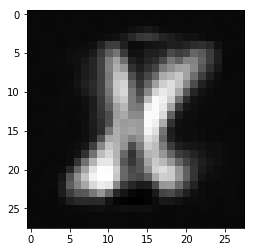

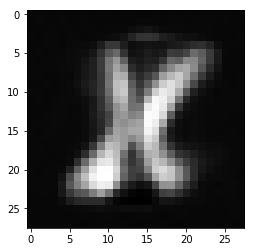

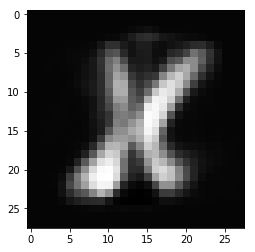

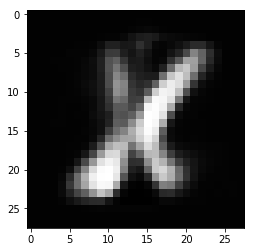

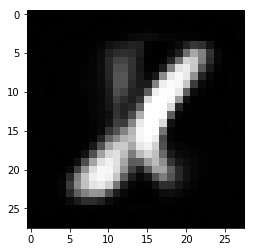

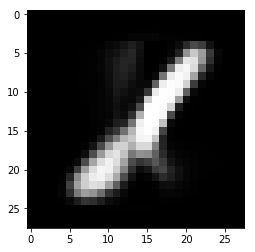

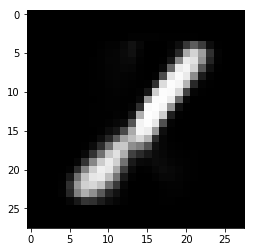

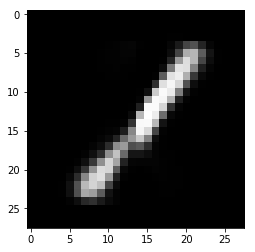

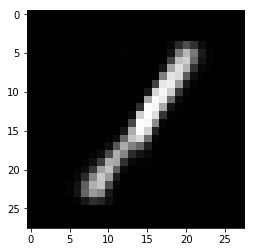

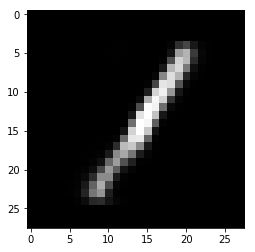

In [192]:
coef = 0.1
res = ae1.predict(np.random.binomial(1,.5,(1,28*28)))

for i in range(10):
    res = ae1.predict(res - coef*np.random.binomial(1,.5,(1,28*28)))
    plt.imshow(res.reshape(28,28),cmap="gray" )
    plt.show()